## Type I Migration Parameter Study (ASTR 211 Final Project)
A study on higher-order resonances in the TRAPPIST-1 system, based on Keller et al. (2026). We want to answer the questions:
- Can Type I migration alone lead to the observed resonant structure?
- How do initial conditions and disk migration parameters map to final resonant outcomes?
More formally, how can I accurately construct a mapping $\mathbf{f}(\mathbf{p}) = \mathbf{o}$ (where $\mathbf{p}$ represents the initial parameters and $\mathbf{o}$ represents the outcome classification).

#### Imports and Units

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pickle
import trappist1_sim as t1
import mmr_id
from time import time
from astropy import units as u
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    
Msun = u.Msun.to(u.g) 
yr = u.yr.to(u.s)    
r_earth = u.earthRad.to(u.AU)
m_earth = u.Mearth.to(u.Msun)
r_sun = u.Rsun.to(u.AU) 

/opt/homebrew/lib/python3.14/site-packages/reboundx/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


#### Generating parameters for the simulation
Based on section 2.1 in Keller et al. (2026). Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

For now, the planetary and stellar parameters are fixed. Hence, the only randomized parameters are the initial period ratios, $\Sigma_{\rm 1au}$ ,and the $K$-factor.

In [ ]:
def generate_params(planet_names):
    # Nested dict containing params for each planet in sim
    # Randomly generate mass, radius, & semimajor axis values
    planet_params = {f"{planet_name}": t1.generate_params_from_csv(f'TRAPPIST-1_params/TRAPPIST-1_{planet_name}_planet_params.csv', ('a (au)', 'Rp (R⨁)', 'Mp (M⨁)'), random=False) for planet_name in planet_names}
    stellar_params = t1.generate_params_from_csv('TRAPPIST-1_params/TRAPPIST-1_stellar_params.csv', ('R✶ (R⦿)', 'M✶ (M⦿)'), random=False)
    
    # Define planet masses (m)
    m_vals = np.array([planet_params[planet_name]['Mp (M⨁)'] for planet_name in planet_names])
    m_vals *= m_earth # convert to Msun

    # Define planet radii (r)
    r_vals = np.array([planet_params[planet_name]['Rp (R⨁)'] for planet_name in planet_names])
    r_vals *= r_earth # convert to AU

    # Define stellar parameters
    m_star = stellar_params['M✶ (M⦿)']
    r_star = stellar_params['R✶ (R⦿)'] * r_sun

    # Draw initial ratios from log normal
    initial_P_ratios = np.random.lognormal(0.5, 0.2, size=len(planet_names)-1) 
                                        # In Keller, 0.703 & 0.313
                                        
    # Draw surface density at 1au from log uniform
    Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=1000, size=1) # in g/cm^2
                                # In Keller, 10 & 10000
    Sigma_1au *= AU**2 / Msun # unit conversion for sim
    # print(f"Sigma_1au: {float(Sigma_1au):.3e}")

    # Draw K-factor from log uniform and solve for h
    K_factor = scipy.stats.loguniform.rvs(a=100, b=300, size=1)
                                # In Keller, 10 & 1000
                                
    return m_vals, r_vals, m_star, r_star, initial_P_ratios, Sigma_1au, K_factor

planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
planet_names = ['b', 'c', 'd', 'e', 'f', 'g']

In [4]:
# Set where to save the data
base_dir = Path.cwd()
file_path = base_dir.parent / "sim_results" / "simulation_data.h5"

#### Main simulation loop

In [ ]:
n_sims = 10
outcomes = []
for i in range(n_sims):
    sim_id = i
    print("==========================")
    print(f"sim_id: {i}")
    
    # Get random param values
    m_vals, r_vals, m_star, r_star, initial_P_ratios, Sigma_1au, K_factor = generate_params(planet_names)
    print(f"Initial P ratios: {np.round(initial_P_ratios, decimals=4)}")
    print(f"Sigma_1au: {np.round(Sigma_1au, decimals=7)}")
    print(f"K-factor: {np.round(K_factor)}")
    
    # Sim integration!
    outcome = t1.simulate_trappist1(m_vals, r_vals, m_star, r_star, initial_P_ratios, Sigma_1au, K_factor, planet_names, sim_id, file_path)
    outcomes.append(outcome)
    print(f"Outcome: {outcome}")

sim_id: 0
Initial P ratios: [1.1252 1.675  1.6188 1.5378 1.658 ]
Sigma_1au: [6.5e-06]
K-factor: [195.]
Integrating 20.0 kyrs 

Integrated to 20.0 kyrs in 48.84 secpleted)
Outcome: 1


In [6]:
with open("trappist1_sim_outcomes.pkl", "wb") as f:
    pickle.dump(outcomes, f)
    
with open("trappist1_sim_outcomes.pkl", "rb") as f:
    sim_outcomes = pickle.load(f)

print(sim_outcomes)

[1]


In [7]:
# Example usage
# print(saved_sim[1]['m_star'])
# print(planets['b'][:5])
# print(planets['b']['a'][:5])
# print(planets['b'].attrs["planet_name"])

In [8]:
# Process data for any given run
sim_id = 0
saved_sim = t1.load_simulation_run(sim_id, file_path)
sim_data = saved_sim[0]
m_star = saved_sim[1]['m_star']
planets = {p: sim_data[p] for p in planet_names}

print(mmr_id.check_resonance(m_star, planets['b'], planets['c']))
print(mmr_id.res_chain_order(saved_sim))
print(mmr_id.res_chain_score(saved_sim))

(3, 2)
1
1


#### Plot it!

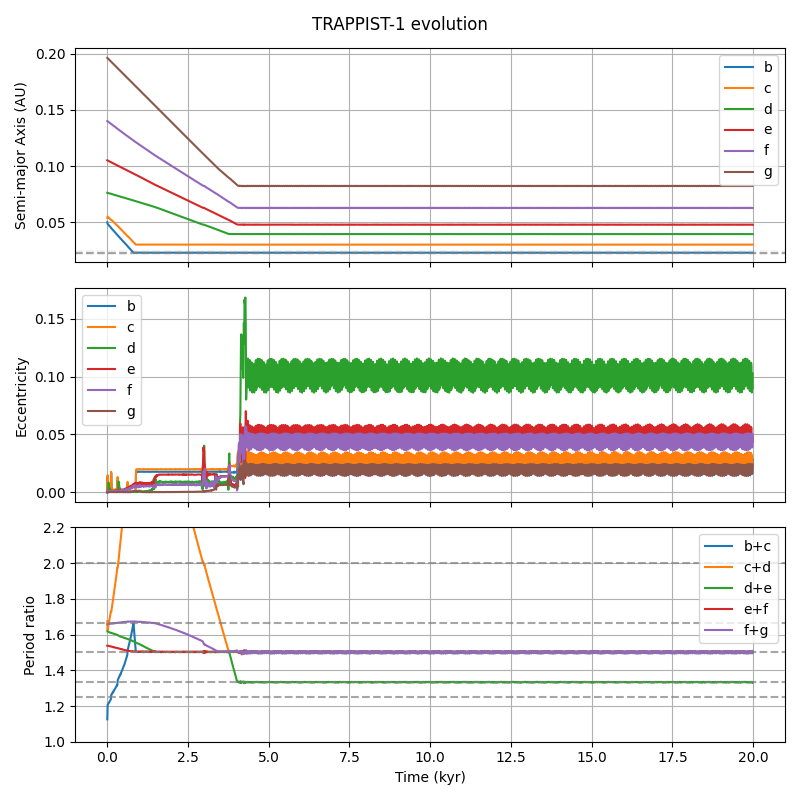

In [9]:
%matplotlib widget
t1.plot_trappist1(saved_sim)

True period ratio: 1.5019
p, q: 3, 2
Libration amplitude: 6.6 deg


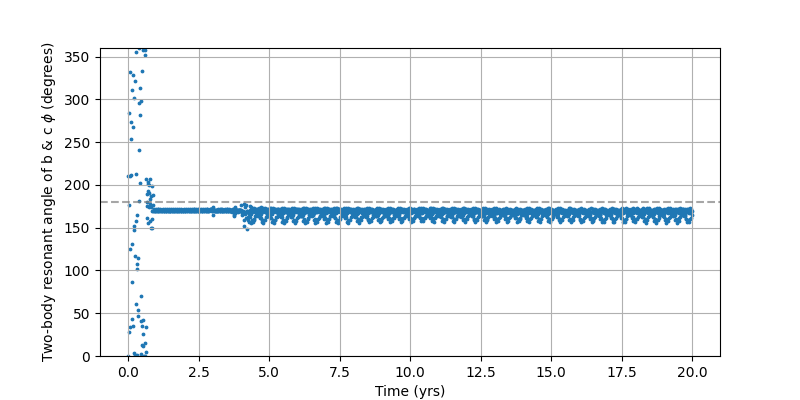

True period ratios: b+c: 1.5019, c+d: 1.4993
p_bc, q_bc, p_cd, q_cd: 3, 2, 3, 2
Libration amplitude: 128.9 deg


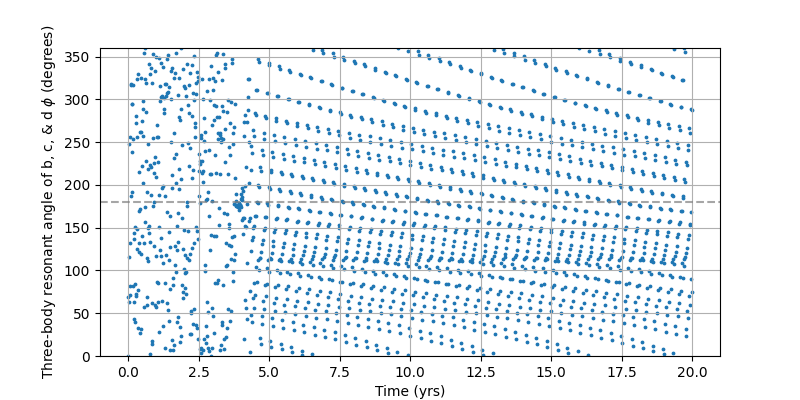

In [10]:
mmr_id.plot_libration(m_star, planets['b'], planets['c'])
mmr_id.plot_libration(m_star, planets['b'], planets['c'], planets['d'])